In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
import timeit
import pyext.src.matrix as mat
import pyext.src.stats as stats

from src.wishart_synthetic_benchmark import (
    ccscatter,
    df_from_stats,
    get_precision_matrix_stats,
    get_prior_pred,
    helper_vline_hist,
    margins_plot,
    quad_plot,
    randPOSDEFMAT,
    rprior,
    rprior_pred,
    sample_from_prior,
    scatter_plot,
    simulate_from_prior,
    try_sampling
    
)

In [2]:
# Flags
MICRO_BENCHMARK_SAMPLING = False
eig10k = False
PAIR_PLOTS = False

In [3]:
# Global Notebook Variables
key = jax.random.PRNGKey(13)
n = 4
shape = 1
dim = 4
df = 2
p = 4

# Image Generating Values From a 2-d Gaussian

xy = -0.9
xx = 1.
yy = 1.
cov = jnp.array([[xx, xy],
                 [xy, yy]])
N=1000

mean = jnp.zeros(2)
data = jax.random.multivariate_normal(key, mean, cov, shape=(N,))

In [4]:
x_stats = stats.get_stats(data[:, 0])
y_stats = stats.get_stats(data[:, 1])

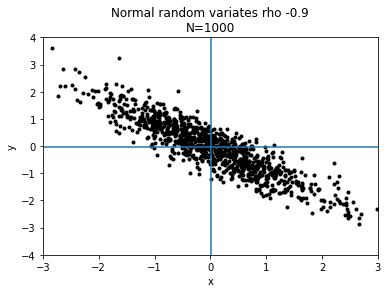

In [5]:
scatter_plot(data[:, 0], data[:, 1], xy=xy)

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


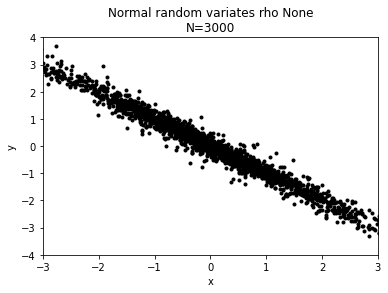

In [6]:
scale = 1.
xy = -0.99
cov_prior = jnp.array([[scale, xy],
                       [xy, scale]])

assert mat.is_positive_definite(cov_prior)

n_samples = 1000
val = jax.jit(partial(get_prior_pred, V=cov_prior, n_samples=n_samples))(key)

x = np.ravel(val.data[:, :, 0])
y = np.ravel(val.data[:, :, 1])
scatter_plot(x, y, )

In [7]:
# What is the largest Matrix this will work on?
if MICRO_BENCHMARK_SAMPLING:
    for p in [24, 48, 96, 128, 256, 512, 1024]:
        try_sampling(key, p)

In [8]:
# What about inverse Covariance Matrices?

"""
Synthetic Data Setup
  64 member pulldown
  4 replicates
  Correlation Structure
    view the image
  mean vector
  
  view the correlation matrix
  view the empircal correlation
  view the precision matrix

Model - Prior Predictive Check
    K ~ Wish
    Sigma = inv(K)
    D ~ N(0, Sigma)
    
Gaussian Model
Updated.
"""

'\nSynthetic Data Setup\n  64 member pulldown\n  4 replicates\n  Correlation Structure\n    view the image\n  mean vector\n  \n  view the correlation matrix\n  view the empircal correlation\n  view the precision matrix\n\nModel - Prior Predictive Check\n    K ~ Wish\n    Sigma = inv(K)\n    D ~ N(0, Sigma)\n    \nGaussian Model\nUpdated.\n'

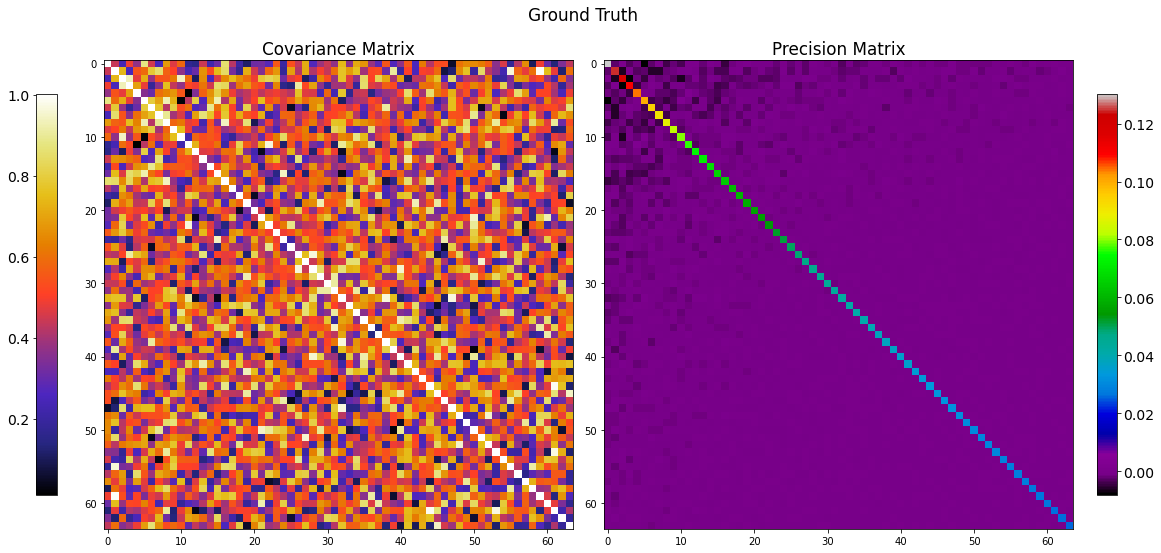

In [9]:
p = 64
k = jax.random.PRNGKey(234762834)
k, k1, k2 = jax.random.split(k, 3)
A = randPOSDEFMAT(k, p)
diag_idx = np.diag_indices(p)
A = A.at[diag_idx].set(jnp.sqrt(A[diag_idx]) + jnp.arange(p) / 2).block_until_ready()
A = np.array(A)

n_replicates = 4
mus = jax.random.normal(k1, shape=(p,))*5
data = jax.random.multivariate_normal(k2, mus, A, shape=(n_replicates,))

assert mat.is_positive_definite(A)

K = np.linalg.inv(A)

#K =  K / np.abs((np.max(K) - np.min(K))) # put two -1, 1
#K = K * 2

font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()

The covariance matrix $A$  
The precision matrix $K=A^{-1}$

In the covariance matrix the off diagonal elements are only dependant on columns X and Y

#### Covariance Matrix $A$
- Diagonals are the Variances
- Off Diagonals are the Covariances (un-normalized correlation)

#### Correlation Matrix corr:
- The covariance matrix of standardized normal variates
- The diagonals are 1
- The off-diagonals are the correlations
  
#### Precision Matrix $K$
$$p_{ij} = K_{ij}$$ Precision matrix off diagonal
partial_correlation 
$$\rho_{X_iX_j\cdot V}=-\frac{K_{ij}}{\sqrt{p_{ii}p_{ij}}}$$



In [10]:

data = np.array(data)
data = data.T
data = pd.DataFrame(data=data)
data["means"] = data.apply(np.mean, axis=1)
data["stds"] = data.apply(np.std, axis=1)
data["vars"] = data.apply(np.var, axis=1)
data["medians"] = data.apply(np.median, axis=1)
diag_idx = np.diag_indices(p)
data["mu"] = np.array(mus)
data["Aii"] = np.array(A[diag_idx])
data["Kii"] = np.array(K[diag_idx])

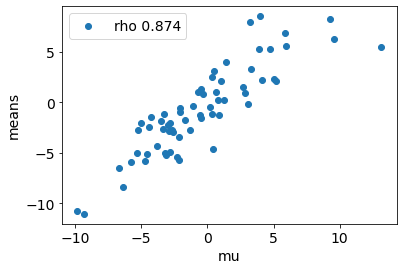

In [11]:
ccscatter(data.mu, data.means)

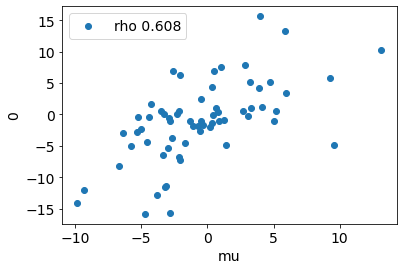

In [12]:
ccscatter(data.mu, data.loc[:, 0])

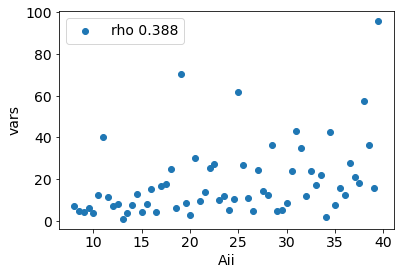

In [13]:
ccscatter(data.Aii, data.vars)

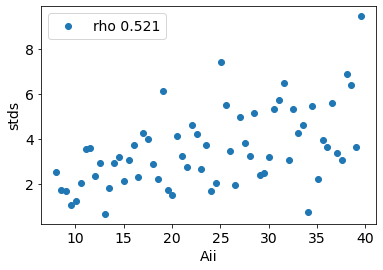

In [14]:
ccscatter(data.Aii, data.stds)

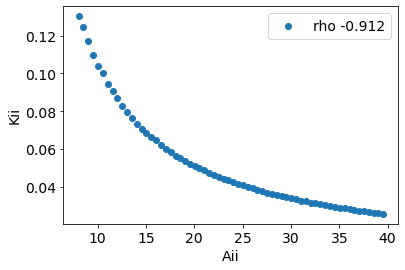

In [15]:
ccscatter(data.Aii, data.Kii)

#### Model 1
 - 64 Independant Gaussians parameterized by their mean and variance
 $$p(d_i | \mu_i, \tau_i) = N(\mu, \tau)$$
 $$ \mu \sim N(\mu_0, 1)$$
 $$ \tau \sim \text{Beta} $$
 $$d_i \sim N(\mu, \tau) $$ 
 
#### Model 2

$$ D \sim N(\mu, \Sigma^{-1})$$

$$ \mu \sim N(\mu_0, \tau_0) $$

$$ \Sigma^{-1} \sim \mathcal{W}_p(\nu, K_0)$$
 - Data $D$ with $n$ replicates and $p$ nodes
 - A $p$ variate Gaussian distribution with
 - $\nu$ degrees of freedom
 - $V$ scale matrix
 - $K_0 = V^{-1}$
 - $n$ observations
 - $p$ variables
 - $Z = D \cdot D^{T}$
 $$ D \sim W_{p}(n + \nu, \space K_0 + Z^{-1}) $$
 
#### Prior Predicitve Check Metrics

#### Prior Comparisons to Ground Truth

$$ K \sim \mathcal{W}_p(\nu, K_0) $$

- sum of the rows
- sum of the columns
- sum of the trace
- min
- max

#####  p-variate metrics
- mean values
- medians
- variances
- min
- max

##### Eigen-values

In [16]:
K_0 = jnp.ones(p) * 0.5 + jnp.eye(p)
n_samples = 1000

jss = jax.jit(partial(sample_from_prior, K_0=K_0, nu=p, p=p, n_samples=n_samples))

val = jss(key)

mat_stats = [get_precision_matrix_stats(K, n) for K in val.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)
#prior_mat_stat_df = prior_mat_stat_df.iloc[:, 1:-1]

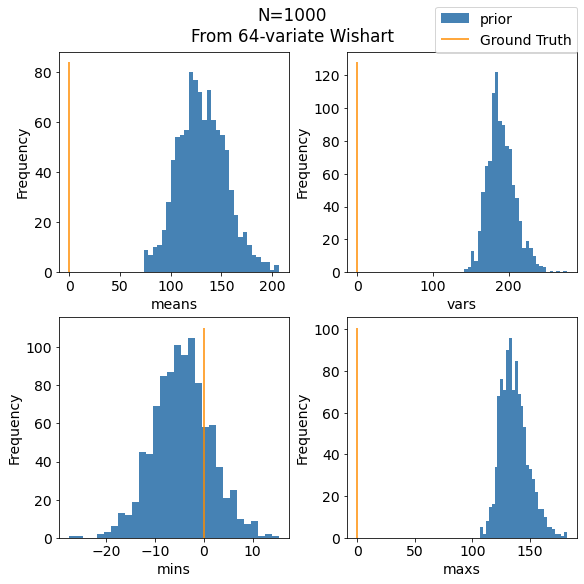

In [17]:
# Initial Model Results
suptitle = f"N={n_samples}\nFrom {p}-variate Wishart"
quad_plot(prior_mat_stat_df, K, n, n_samples, font_rc=font_rc, p=p, suptitle=suptitle)

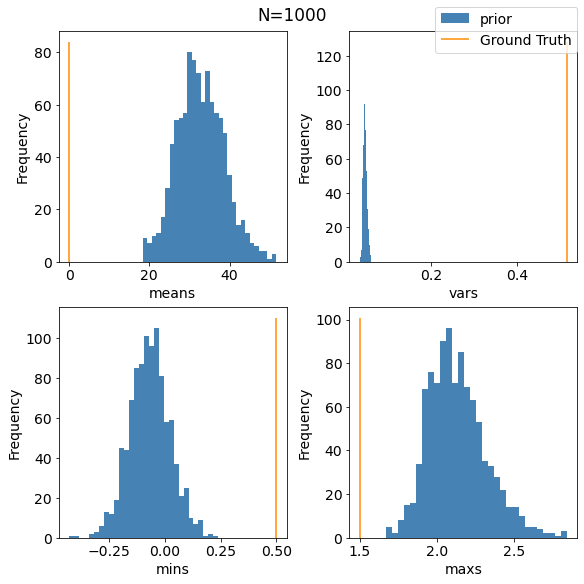

In [18]:
# Try a new K0, reuse key
p=64
n=64
ground_truth = K_0
K0 = 1/n * K_0
n_samples = 1000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n)
quad_plot(df, ground_truth, n_samples=n_samples,
         n=n,
         font_rc=font_rc, p=p)

In [19]:
# Try a new K0, reuse key

p=64
n=64
K0 = 1/n * K
n_samples = 10000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n=n)

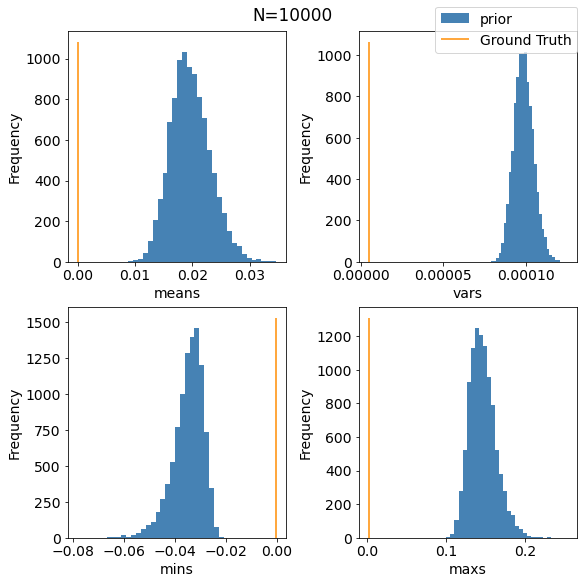

In [20]:
quad_plot(df, K0, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [21]:
# Lets look at the top 4 eigenvalues

if eig10k:
    ground_truth = sp.linalg.eigh(K, eigvals_only=True, check_finite=True)

    eigs = np.zeros((len(val.samples), p))
    for i in range(len(val.samples)):
        eigs[i] = sp.linalg.eigh(val.samples[i], eigvals_only=True, check_finite=True)
    

In [22]:
if PAIR_PLOTS:
    m = 8
    scale = 16
    w = 1 * scale
    h = 1 * scale
    bins=30
    hcolor="steelblue"
    vcolor="darkorange"
    fig, axs = plt.subplots(m, m, layout="constrained")
    fig.set_figheight(h)
    fig.set_figwidth(w)

    count = -1
    for i in range(m):
        for j in range(m):
            count +=1
            ax = axs[i, j]
            eigvals = eigs[:, count]
            vx = ground_truth[count]
            ymin = 0

            vlabel = f"K eigenvalues" if count == m*m-1 else None
            hlabel = f"prior samples" if count == m*m-1 else None

            #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                             #vcolor, hcolor, bins, ylabel=None, xlabel=None)



            ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
            ymax = ax.get_ylim()[1]
            ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

            #ax.scatter(x, y)
        plt.suptitle(f"N={n_samples}")
    plt.show()

In [23]:
# A simpler Case

cov = np.array([[1., -0.2],
                [-0.2, 1.]])

cov_inv = sp.linalg.inv(cov)
nu = 2
n=2
p = 2
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)
samples = sample_from_prior(key, nu, p, n_samples, K0)

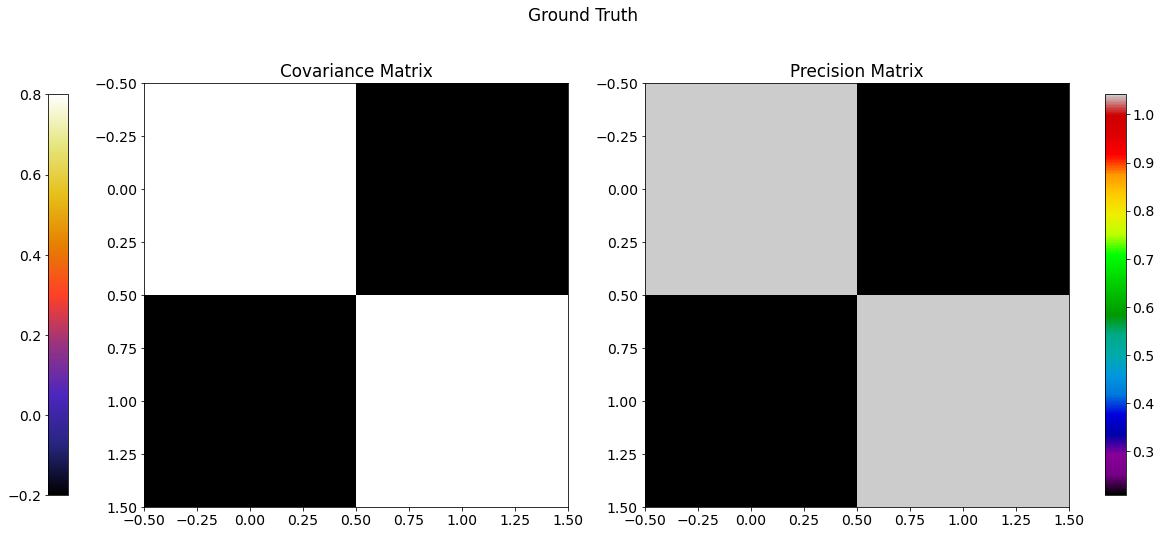

In [24]:
t1 = A
t2 = K
A = cov
K = cov_inv
font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()
A = t1
K = t2

In [25]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

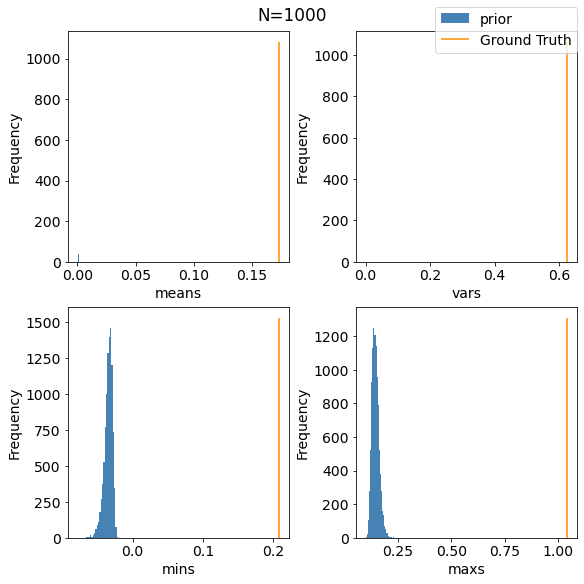

In [26]:
quad_plot(df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [27]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

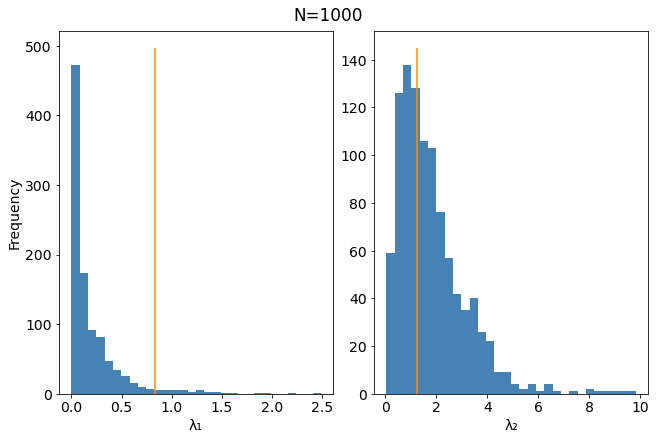

In [28]:
m = 2
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, 2, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

In [29]:
# More Complex 3 x 3

cov = np.array([[1., 0., 0.2],
                [0., 0.3, -0.5],
                [0.2, -0.5, 1.3]])

assert mat.is_positive_definite(cov)

cov_inv = sp.linalg.inv(cov)
nu = 3
n=3
p = 3
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)

samples = sample_from_prior(key, nu, p, n_samples, K0)

In [30]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

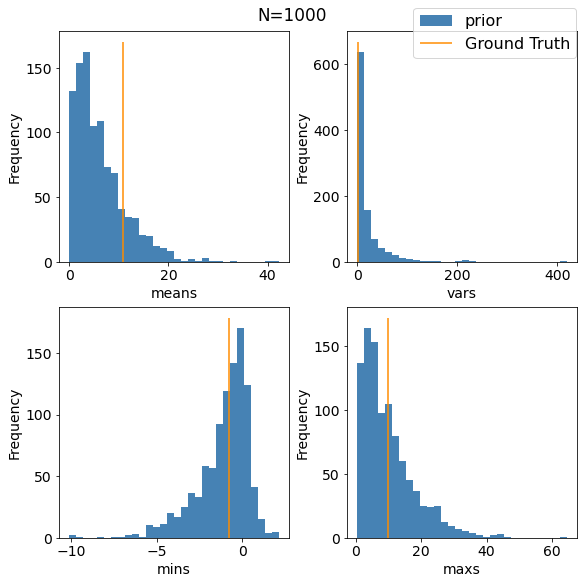

In [31]:
quad_plot(prior_mat_stat_df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [41]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

In [43]:
assert ground_truth.shape == (3,)
assert eigs.shape == (n_samples, 3)

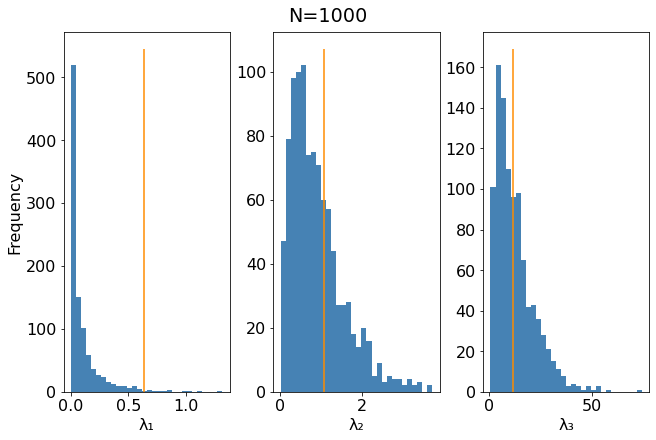

In [44]:
m = 3
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, m, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

In [34]:
example_string = "A0B1C2D3E4F5G6H7I8J9"

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

print(example_string.translate(SUP))
print(example_string.translate(SUB))

A⁰B¹C²D³E⁴F⁵G⁶H⁷I⁸J⁹
A₀B₁C₂D₃E₄F₅G₆H₇I₈J₉


In [35]:
?sp.linalg.eigh

In [36]:
wK, vK = sp.linalg.eigh(K)

array([[2.05676839e-01, 1.46643686e+00, 6.20345354e+00],
       [7.41519965e-04, 2.71465182e+00, 4.00161457e+00],
       [1.85429992e-03, 1.23769686e-01, 1.70592003e+01],
       ...,
       [1.60223767e-01, 4.96616125e-01, 2.80475235e+00],
       [8.65591615e-02, 1.23766565e+00, 3.37715101e+00],
       [1.71845272e-01, 9.39921498e-01, 4.19401073e+00]])

In [38]:
sp.linalg.eigh(K, eigvals_only=True, check_finite=True)

array([0.01731002, 0.02536188, 0.02575271, 0.02616422, 0.02670176,
       0.02702415, 0.02742952, 0.02753662, 0.02823522, 0.02858718,
       0.02867257, 0.02962489, 0.03019758, 0.03035369, 0.03081485,
       0.03123518, 0.03205014, 0.0324176 , 0.03299746, 0.03344088,
       0.03402445, 0.03443829, 0.03539998, 0.03583525, 0.03630502,
       0.03757942, 0.03814172, 0.03867278, 0.03986302, 0.04001091,
       0.04160965, 0.04253871, 0.04282939, 0.0443901 , 0.0452347 ,
       0.04683425, 0.04720912, 0.04905855, 0.04936395, 0.05048266,
       0.05216394, 0.05344137, 0.05527747, 0.05650603, 0.05730451,
       0.06050491, 0.06106148, 0.06349407, 0.0670114 , 0.06855835,
       0.07061176, 0.07335117, 0.07656129, 0.0785934 , 0.08274914,
       0.08556147, 0.09110158, 0.09695927, 0.10295116, 0.10479981,
       0.11143708, 0.1201596 , 0.12983017, 0.13655992], dtype=float32)